In [ ]:
# !pip install -U pip setuptools wheel
# !pip install -U 'spacy[cuda11x]'
# !python -m spacy download en_core_web_sm

In [1]:
import json
import spacy
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding
from transformers import TrainingArguments, Trainer
from datasets import Dataset
import numpy as np
from datasets import load_metric
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score

import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer, BertForNextSentencePrediction, AdamW


## Data Preprocess

### Entire Dataset

In [2]:
dataset_path = 'full_dataset.json'

# Read the JSON file
with open(dataset_path, 'r') as file:
    data = json.load(file)

In [3]:
data[:1]

[{'conversation_ID': 1,
  'conversation': [{'utterance_ID': 1,
    'text': 'Alright , so I am back in high school , I am standing in the middle of the cafeteria , and I realize I am totally naked .',
    'speaker': 'Chandler',
    'emotion': 'neutral'},
   {'utterance_ID': 2,
    'text': 'Oh , yeah . Had that dream .',
    'speaker': 'All',
    'emotion': 'neutral'},
   {'utterance_ID': 3,
    'text': 'Then I look down , and I realize there is a phone ... there .',
    'speaker': 'Chandler',
    'emotion': 'surprise'},
   {'utterance_ID': 4,
    'text': 'Instead of ... ?',
    'speaker': 'Joey',
    'emotion': 'surprise'},
   {'utterance_ID': 5,
    'text': 'That is right .',
    'speaker': 'Chandler',
    'emotion': 'anger'},
   {'utterance_ID': 6,
    'text': 'Never had that dream .',
    'speaker': 'Joey',
    'emotion': 'neutral'},
   {'utterance_ID': 7,
    'text': 'No .',
    'speaker': 'Phoebe',
    'emotion': 'neutral'},
   {'utterance_ID': 8,
    'text': 'All of a sudden , the

In [4]:
conversations_ids = []
conversations = []

for obj in data:
    conversations_ids.append(obj['conversation_ID'])
    conversations.append(obj['conversation'])

In [5]:
len(conversations_ids)

1374

In [6]:
len(conversations)

1374

In [7]:
conversations[:1]

[[{'utterance_ID': 1,
   'text': 'Alright , so I am back in high school , I am standing in the middle of the cafeteria , and I realize I am totally naked .',
   'speaker': 'Chandler',
   'emotion': 'neutral'},
  {'utterance_ID': 2,
   'text': 'Oh , yeah . Had that dream .',
   'speaker': 'All',
   'emotion': 'neutral'},
  {'utterance_ID': 3,
   'text': 'Then I look down , and I realize there is a phone ... there .',
   'speaker': 'Chandler',
   'emotion': 'surprise'},
  {'utterance_ID': 4,
   'text': 'Instead of ... ?',
   'speaker': 'Joey',
   'emotion': 'surprise'},
  {'utterance_ID': 5,
   'text': 'That is right .',
   'speaker': 'Chandler',
   'emotion': 'anger'},
  {'utterance_ID': 6,
   'text': 'Never had that dream .',
   'speaker': 'Joey',
   'emotion': 'neutral'},
  {'utterance_ID': 7,
   'text': 'No .',
   'speaker': 'Phoebe',
   'emotion': 'neutral'},
  {'utterance_ID': 8,
   'text': 'All of a sudden , the phone starts to ring .',
   'speaker': 'Chandler',
   'emotion': 'neu

### Train Dataset

In [8]:
dataset_path = 'train_dataset.json'

# Read the JSON file
with open(dataset_path, 'r') as file:
    train = json.load(file)

# print(train)

In [9]:
train_ids = train['conversation_ID']

In [10]:
train_conversations = train['conversation']
print(train_conversations['535'])

[{'utterance_ID': 1, 'text': 'Oh hey Joey ! What up ?', 'speaker': 'Phoebe', 'emotion': 'joy'}, {'utterance_ID': 2, 'text': 'I can not decide which route to take to Vegas . Hey , you have traveled a lot right ?', 'speaker': 'Joey', 'emotion': 'neutral'}, {'utterance_ID': 3, 'text': 'Yeah , I have been around .', 'speaker': 'Phoebe', 'emotion': 'neutral'}, {'utterance_ID': 4, 'text': 'Okay , so ... so which route should I take the northern route or the southern route ?', 'speaker': 'Joey', 'emotion': 'neutral'}, {'utterance_ID': 5, 'text': 'Ooh , if you take the northern route there is a man in Illinois with a beard of bees .', 'speaker': 'Phoebe', 'emotion': 'neutral'}, {'utterance_ID': 6, 'text': 'Great ! Problem solved !', 'speaker': 'Joey', 'emotion': 'joy'}]


#### Emotion distribution

In [17]:
emotions_counts = {
    "anger": 0,
    "disgust": 0,
    "fear": 0,
    "joy": 0,
    "neutral": 0,
    "sadness": 0,
    "surprise": 0
}
for conv_id, conversation in train_conversations.items():
    for utterance in conversation:
        # print(utterance)
        emotions_counts[utterance['emotion']] += 1

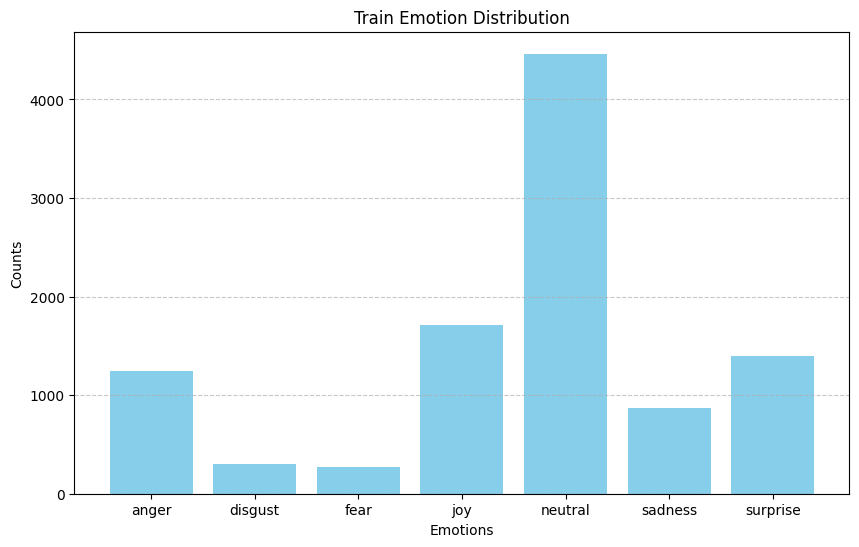

In [24]:
# Data
emotion_counts = {
    'anger': 1241,
    'disgust': 303,
    'fear': 267,
    'joy': 1707,
    'neutral': 4464,
    'sadness': 871,
    'surprise': 1393
}

# Create lists of emotions and their counts
emotions = list(emotion_counts.keys())
counts = list(emotion_counts.values())

# Plotting
plt.figure(figsize=(10, 6))  # Adjust the size of the plot as needed
plt.bar(emotions, counts, color='skyblue')  # You can choose your own color

# Adding titles and labels
plt.title('Train Emotion Distribution')
plt.xlabel('Emotions')
plt.ylabel('Counts')

# Optionally, you can add a grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

### Test Dataset

In [11]:
dataset_path = 'test_dataset.json'

# Read the JSON file
with open(dataset_path, 'r') as file:
    test = json.load(file)

# print(test)
test_ids = test['conversation_ID']


In [12]:
test_conversations = test['conversation']
print(test_conversations['430'])

[{'utterance_ID': 1, 'text': 'Hey !', 'speaker': 'Joey', 'emotion': 'joy'}, {'utterance_ID': 2, 'text': 'So , what are you guys in the market for ? We have got uh , scarves , tulip post cards ...', 'speaker': 'The Vendor', 'emotion': 'neutral'}, {'utterance_ID': 3, 'text': 'Check this out ? Huh ? Yeah . That is the stuff . What do you think ?', 'speaker': 'Joey', 'emotion': 'joy'}, {'utterance_ID': 4, 'text': 'Well , I do not have to buy that , " I am with stupid " T ... shirt anymore .', 'speaker': 'Chandler', 'emotion': 'neutral'}, {'utterance_ID': 5, 'text': 'Well , I like it . Here you go .', 'speaker': 'Joey', 'emotion': 'neutral'}, {'utterance_ID': 6, 'text': 'All right , look , you are not really gonna buy that are you ? Do not you think you have embarrassed me enough for one day ?', 'speaker': 'Chandler', 'emotion': 'anger'}, {'utterance_ID': 7, 'text': 'Oh , I embarrass you ?', 'speaker': 'Joey', 'emotion': 'surprise'}, {'utterance_ID': 8, 'text': 'How can I answer that when I

#### Emotion Distribution

In [20]:
emotions_counts = {
    "anger": 0,
    "disgust": 0,
    "fear": 0,
    "joy": 0,
    "neutral": 0,
    "sadness": 0,
    "surprise": 0
}
for conv_id, conversation in test_conversations.items():
    for utterance in conversation:
        # print(utterance)
        emotions_counts[utterance['emotion']] += 1

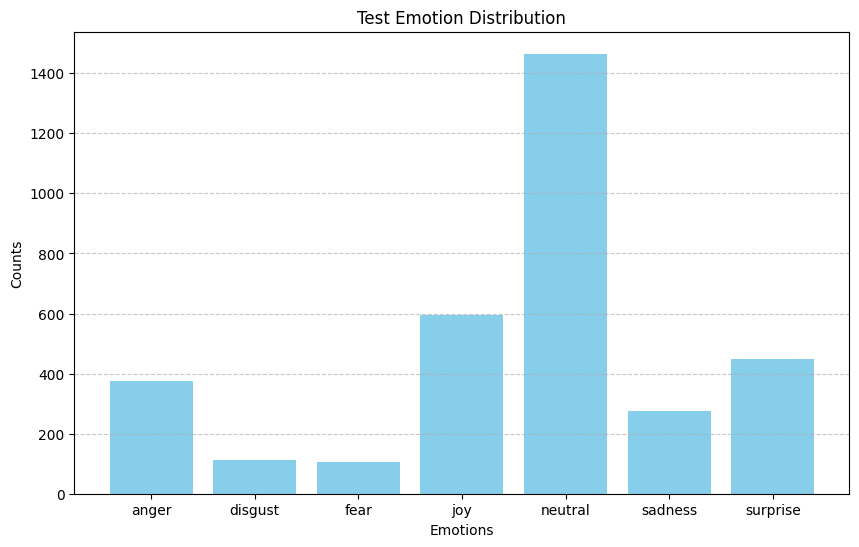

In [23]:
# Data
emotion_counts = {
    'anger': 374,
    'disgust': 111,
    'fear': 106,
    'joy': 594,
    'neutral': 1465,
    'sadness': 276,
    'surprise': 447
}

# Create lists of emotions and their counts
emotions = list(emotion_counts.keys())
counts = list(emotion_counts.values())

# Plotting
plt.figure(figsize=(10, 6))  # Adjust the size of the plot as needed
plt.bar(emotions, counts, color='skyblue')  # You can choose your own color

# Adding titles and labels
plt.title('Test Emotion Distribution')
plt.xlabel('Emotions')
plt.ylabel('Counts')

# Optionally, you can add a grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

# Subtask 0

#### Inference Example (no training)

In [48]:
# Load spaCy model for tokenization and dependency parsing
nlp = spacy.load("en_core_web_sm")

# Load a pre-trained emotion classification model from Hugging Face
emotion_classifier = pipeline("sentiment-analysis", model="michellejieli/emotion_text_classifier")

#### Tokenizer

In [89]:
# tokenizer = AutoTokenizer.from_pretrained("distilroberta-base")
tokenizer = AutoTokenizer.from_pretrained("thesergiu/finetuning-sentiment-model-10k-samples")

tokenizer_config.json:   0%|          | 0.00/1.22k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

In [90]:
tokenized_output = tokenizer("Oh, look, wish me luck!", truncation=True)
print(tokenized_output['input_ids'], tokenized_output['attention_mask'])
print(type(tokenized_output['input_ids']), type(tokenized_output['attention_mask']))

[0, 7516, 6, 356, 6, 2813, 162, 6620, 328, 2] [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
<class 'list'> <class 'list'>


#### Train Data

In [91]:
emotion2int = {
    "anger": 0,
    "disgust": 1,
    "fear": 2,
    "joy": 3,
    "neutral": 4,
    "sadness": 5,
    "surprise": 6
}

# int2emotion = {
#     "anger": 0,
#     "disgust": 1,
#     "fear": 2,
#     "joy": 3,
#     "neutral": 4,
#     "sadness": 5,
#     "surprise": 6
# }

In [92]:
train_inputs = []
labels = []
train_input_ids = []
train_attention_mask = []
train_labels2num = []

for id, conversation in train_conversations.items():
    for utterance in conversation:
        train_inputs.append(utterance['text'])
        output = tokenizer(utterance['text'])
        train_input_ids.append(output["input_ids"])
        train_attention_mask.append(output["attention_mask"])
        labels.append(utterance['emotion'])
        train_labels2num.append(emotion2int[utterance['emotion']])

print(len(train_input_ids), len(labels), len(train_attention_mask), len(train_labels2num))
print(train_inputs[0], train_input_ids[0], train_attention_mask[0], labels[0], train_labels2num[0])

10246 10246 10246 10246
Oh hey Joey ! What up ? [0, 7516, 17232, 12972, 27785, 653, 62, 17487, 2] [1, 1, 1, 1, 1, 1, 1, 1, 1] joy 3


In [93]:
data = {
    # "text": train_inputs,
    "labels": train_labels2num,
    "input_ids": train_input_ids,
    "attention_mask": train_attention_mask
}
df = pd.DataFrame(data)
train_dataset = Dataset.from_pandas(df)

In [94]:
train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])

In [95]:
print(train_dataset)

Dataset({
    features: ['labels', 'input_ids', 'attention_mask'],
    num_rows: 10246
})


#### Test Data

In [96]:
test_inputs = []
test_tokenized_inputs = []
test_labels = []
test_input_ids = []
test_attention_mask = []
test_labels2num = []

for id, conversation in test_conversations.items():
    for utterance in conversation:
        test_inputs.append(utterance['text'])
        # test_tokenized_inputs.append(tokenizer(utterance['text'], truncation=True))
        output = tokenizer(utterance['text'])
        test_input_ids.append(output["input_ids"])
        test_attention_mask.append(output["attention_mask"])
        test_labels.append(utterance['emotion'])
        test_labels2num.append(emotion2int[utterance['emotion']])

print(len(test_input_ids), len(test_labels), len(test_attention_mask), len(test_labels2num))
print(test_inputs[0],test_input_ids[0], test_attention_mask[0], test_labels[0], test_labels2num[0])

3373 3373 3373 3373
Hey ! [0, 13368, 27785, 2] [1, 1, 1, 1] joy 3


In [97]:
data = {
    # "text": test_inputs,
    "labels": test_labels2num,
    "input_ids": test_input_ids,
    "attention_mask": test_attention_mask
}
df = pd.DataFrame(data)
test_dataset = Dataset.from_pandas(df)
print(test_dataset.column_names)
print(test_dataset)

['labels', 'input_ids', 'attention_mask']
Dataset({
    features: ['labels', 'input_ids', 'attention_mask'],
    num_rows: 3373
})


In [98]:
test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])

In [99]:
# print(test_dataset['text'][0])

#### Create Tokenized Datasets

In [100]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

#### Model

In [101]:
# model = AutoModelForSequenceClassification.from_pretrained(
#     "michellejieli/emotion_text_classifier", 
# )

model = AutoModelForSequenceClassification.from_pretrained(
    "thesergiu/finetuning-sentiment-model-10k-samples", 
)

In [102]:
def compute_metrics(eval_pred):
   load_accuracy = load_metric("accuracy", trust_remote_code=True)
   # load_f1 = load_metric("f1")
  
   logits, labels = eval_pred
   predictions = np.argmax(logits, axis=-1)
   accuracy = load_accuracy.compute(predictions=predictions, references=labels)["accuracy"]
   # f1 = load_f1.compute(predictions=predictions, references=labels)["f1"]
   return {"accuracy": accuracy}

In [103]:
# from huggingface_hub import notebook_login
# notebook_login()

### Results

| Model | Epochs | Train Accuracy | Test Accuracy |
|-------|--------|----------------|---------------|| michellejieli/emotion_text_classifier      |  2      |     0.753           |     0.679          |
|michellejieli/emotion_text_classifier       | 20       |      0.955          |    0.646          | |
michellejieli/emotion_text_classiier|     5            |      0.966          |      0.645                 |


In [104]:
repo_name = "finetuning-sentiment-model-10k-samples"
 
training_args = TrainingArguments(
   output_dir=repo_name,
   learning_rate=2e-4,
   per_device_train_batch_size=128,
   per_device_eval_batch_size=128,
   num_train_epochs=2,
   weight_decay=0.1,
   save_strategy="epoch",
   # push_to_hub=True,
)
 
trainer = Trainer(
   model=model,
   args=training_args,
   train_dataset=train_dataset,
   eval_dataset=test_dataset,
   tokenizer=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics,
)


In [78]:
# trainer.train()

Step,Training Loss


TrainOutput(global_step=162, training_loss=0.9931683952425733, metrics={'train_runtime': 24.8497, 'train_samples_per_second': 824.639, 'train_steps_per_second': 6.519, 'total_flos': 238040301409344.0, 'train_loss': 0.9931683952425733, 'epoch': 2.0})

In [105]:
trainer.evaluate()

You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'eval_loss': 1.0844780206680298,
 'eval_accuracy': 0.640972428105544,
 'eval_runtime': 1.9363,
 'eval_samples_per_second': 1741.997,
 'eval_steps_per_second': 13.944}

In [106]:
trainer.predict(train_dataset)

PredictionOutput(predictions=array([[ 0.39949837, -1.8105557 , -1.6570587 , ...,  1.2467072 ,
        -1.4840589 ,  1.1244258 ],
       [-0.0615969 , -1.3461576 , -1.2526312 , ...,  2.9516232 ,
         0.84837496, -1.4922618 ],
       [-0.3151899 , -1.6356266 , -1.8009752 , ...,  3.7774699 ,
         0.48883063, -1.9778042 ],
       ...,
       [-0.03455137, -1.2291783 , -0.9258614 , ...,  2.2838361 ,
         0.64484954, -1.6744637 ],
       [ 0.1401683 , -0.48357072, -1.8899697 , ...,  0.6047044 ,
        -0.39588556,  3.099468  ],
       [ 0.02174205, -0.487102  , -0.7052406 , ...,  1.7304311 ,
         0.7740062 , -0.82224655]], dtype=float32), label_ids=array([3, 4, 4, ..., 6, 6, 4]), metrics={'test_loss': 0.8417397141456604, 'test_accuracy': 0.7266250243997657, 'test_runtime': 3.8652, 'test_samples_per_second': 2650.85, 'test_steps_per_second': 20.956})

In [107]:
trainer.predict(test_dataset)

PredictionOutput(predictions=array([[ 0.40460837, -1.4400575 , -2.0164084 , ...,  1.8971832 ,
        -1.6272271 ,  0.2941543 ],
       [-0.23048702, -1.3986528 , -1.9813193 , ...,  3.7786705 ,
        -0.47103003, -0.37560523],
       [ 0.00750665, -1.1659061 , -1.6214137 , ...,  1.5149518 ,
        -0.61382085,  2.1203957 ],
       ...,
       [ 1.6514231 , -0.30944082, -1.6659166 , ...,  1.5042416 ,
        -0.38710153, -1.5783656 ],
       [ 0.7180482 , -0.38061285, -1.275393  , ...,  0.5659094 ,
        -0.10494567,  1.7350239 ],
       [-0.19089878, -0.6434145 , -1.6065603 , ...,  3.6776083 ,
        -0.05840236, -2.2797031 ]], dtype=float32), label_ids=array([3, 4, 3, ..., 4, 5, 4]), metrics={'test_loss': 1.0844780206680298, 'test_accuracy': 0.640972428105544, 'test_runtime': 1.5675, 'test_samples_per_second': 2151.842, 'test_steps_per_second': 17.225})

# Subtask 1

### Data Exploration

- let's say we have a good emotion classifier (i.e. 65%).
- a sentence with an emotion is always a pair with itself.
- for each conversation, we will look at the emotion-cause pairs. we will attempt to create all causal (possible) pairs, and use BERT to predict whether 2 sentences are 'related' by formulating this as a Next Sentence Prediction (NSP) task.

#### 1. Train and Predict NSP with BERT
- We wil take all pairs which exist. Pairs fround within the ground truth are marked as 1 (true), and others which are not as 0 (false)
- Exclude pairs which are associated with the same sentence - this responsiblity is passed onto the sentiment analysis model, which will include that sentence as a pair if it detects an emotion (other than neutral).
- We will check our 'accuracy' for the NSP task on all causal pairs excluding self-matching (i.e. 1-2, 1-3, 1-4, 2-3, etc.)

#### 2. Check Emotion-Cause Pairs Accuracy (without span)
- We will check our accuracy (or F1) on the emotion-cause pair (without span) by checking for the presence of our emotion-cause pairs, either resulting from the NSP, or from our sentiment prediction model (which in our case will only include self-matched sentences)

In [13]:
train.keys()

dict_keys(['conversation_ID', 'conversation', 'emotion-cause_pairs'])

In [14]:
list(train['emotion-cause_pairs'].keys())[:6]

['535', '890', '1370', '371', '96', '1273']

#### Example 1

In [15]:
train['conversation']['535']

[{'utterance_ID': 1,
  'text': 'Oh hey Joey ! What up ?',
  'speaker': 'Phoebe',
  'emotion': 'joy'},
 {'utterance_ID': 2,
  'text': 'I can not decide which route to take to Vegas . Hey , you have traveled a lot right ?',
  'speaker': 'Joey',
  'emotion': 'neutral'},
 {'utterance_ID': 3,
  'text': 'Yeah , I have been around .',
  'speaker': 'Phoebe',
  'emotion': 'neutral'},
 {'utterance_ID': 4,
  'text': 'Okay , so ... so which route should I take the northern route or the southern route ?',
  'speaker': 'Joey',
  'emotion': 'neutral'},
 {'utterance_ID': 5,
  'text': 'Ooh , if you take the northern route there is a man in Illinois with a beard of bees .',
  'speaker': 'Phoebe',
  'emotion': 'neutral'},
 {'utterance_ID': 6,
  'text': 'Great ! Problem solved !',
  'speaker': 'Joey',
  'emotion': 'joy'}]

In [16]:
conversation = train['conversation']['535']
conversation[-1]

{'utterance_ID': 6,
 'text': 'Great ! Problem solved !',
 'speaker': 'Joey',
 'emotion': 'joy'}

In [17]:
train['emotion-cause_pairs']['535']

[['1_joy', '1_Oh hey Joey !'],
 ['6_joy',
  '5_if you take the northern route there is a man in Illinois with a beard of bees .'],
 ['6_joy', '6_Great ! Problem solved !']]

#### Example 2

In [28]:
train['conversation']['890']

[{'utterance_ID': 1, 'text': 'Hi .', 'speaker': 'Phoebe', 'emotion': 'joy'},
 {'utterance_ID': 2,
  'text': 'Listen , I am sorry about that whole thing with Roger .',
  'speaker': 'Phoebe',
  'emotion': 'sadness'},
 {'utterance_ID': 3,
  'text': 'It really was not right , and I , and I want to make it up to you , so umm , I brought you something that I think you will really enjoy .',
  'speaker': 'Phoebe',
  'emotion': 'neutral'},
 {'utterance_ID': 4,
  'text': 'Now , this is just a loan .',
  'speaker': 'Phoebe',
  'emotion': 'neutral'},
 {'utterance_ID': 5,
  'text': 'Okay ?',
  'speaker': 'Phoebe',
  'emotion': 'neutral'},
 {'utterance_ID': 6,
  'text': 'I am gonna , I am gonna want him back .',
  'speaker': 'Phoebe',
  'emotion': 'neutral'},
 {'utterance_ID': 7,
  'text': 'So ... I am gonna go now .',
  'speaker': 'Phoebe',
  'emotion': 'neutral'},
 {'utterance_ID': 8,
  'text': 'I am sorry , I thought I could do it and I can not !',
  'speaker': 'Phoebe',
  'emotion': 'sadness'}]

In [24]:
train['emotion-cause_pairs']['890']

[['1_joy', '1_Hi .'],
 ['2_sadness', '2_I am sorry about that whole thing with Roger .'],
 ['8_sadness', '8_I thought I could do it and I can not !']]

#### Example 3

In [25]:
train['emotion-cause_pairs']['1370']

[['1_fear', '1_if there is a reason why we can not have a baby'],
 ['3_joy',
  '2_You and Monica are meant to have children . I am sure it is gonna be just fine .'],
 ['4_surprise', '4_I did not even think of that .'],
 ['5_sadness',
  '5_I was just so worried about having to ... come here and do ... that ...'],
 ['6_surprise',
  '5_I was just so worried about having to ... come here and do ... that ...'],
 ['6_surprise',
  '6_you can do it in the parking lot of a Taco Bell , but you can not do it at a doctor office ?'],
 ['7_anger',
  '6_you can do it in the parking lot of a Taco Bell , but you can not do it at a doctor office ?']]

In [26]:
train['emotion-cause_pairs']['371']

[['5_surprise', '1_Would you ever be a surrogate for anyone ?'],
 ['5_surprise', '2_It depends on who asked .'],
 ['5_surprise', '3_What if I asked ?'],
 ['5_surprise', '4_Oh , Mon , sure .'],
 ['6_fear', '6_You are not asking are you ?'],
 ['8_joy', '6_You are not asking are you ?'],
 ['8_joy', '7_No .']]

#### Data Pre-Processing Subtask 1

In [18]:
def preprocess_ec_pairs(ec_pairs_list):
    ec_ids = []
    
    for pair in ec_pairs_list:
        utt_id_emotion, emotion = pair[0].split('_')[0], pair[0].split('_')[1]
        utt_id_cause, span = pair[1].split('_')[0], pair[1].split('_')[1]
        ec_ids.append((utt_id_emotion, utt_id_cause))

    return ec_ids

def non_self_matching_ec_pairs(ec_ids):
    non_matching_ids = []
    for pair in ec_ids:
        if pair[0] == pair[1]:
            continue
        non_matching_ids.append(pair)
    return non_matching_ids

def inverse_non_self_matching_ec_pairs_for_nsp(non_matching_ids):
    inversed_non_matching_ids = []
    for pair in non_matching_ids:
       inversed_non_matching_ids.append((int(pair[1]), int(pair[0])))
    return set(inversed_non_matching_ids)

def return_causal_range_tuples(start, end):
    # Generate all causal pairs within the given range
    causal_pairs = [(i, j) for i in range(start, end) for j in range(i+1, end + 1)]
    
    return causal_pairs

In [19]:
ec_ids = preprocess_ec_pairs(train['emotion-cause_pairs']['371'])
print(ec_ids)

[('5', '1'), ('5', '2'), ('5', '3'), ('5', '4'), ('6', '6'), ('8', '6'), ('8', '7')]


In [20]:
non_matching = non_self_matching_ec_pairs(ec_ids)
print(non_matching)

[('5', '1'), ('5', '2'), ('5', '3'), ('5', '4'), ('8', '6'), ('8', '7')]


In [21]:
print(inverse_non_self_matching_ec_pairs_for_nsp(non_matching))

{(1, 5), (6, 8), (4, 5), (7, 8), (2, 5), (3, 5)}


## 1. Train BERT for NSP

In [22]:
from transformers import BertTokenizer, BertForNextSentencePrediction
import torch

In [23]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForNextSentencePrediction.from_pretrained('bert-base-uncased')

#### Example

In [24]:
# Example
text = ("After Abraham Lincoln won the November 1860 presidential election on an "
        "anti-slavery platform, an initial seven slave states declared their "
        "secession from the country to form the Confederacy.")
text2 = ("War broke out in April 1861 when secessionist forces attacked Fort "
         "Sumter in South Carolina, just over a month after Lincoln's "
         "inauguration.")

# Tokenization
inputs = tokenizer(text, text2, return_tensors='pt')
print(inputs.keys())

# Create Class Label
labels = torch.LongTensor([0])
print(labels)

# Compute Loss
outputs = model(**inputs, labels=labels)
print("Outputs:", outputs.keys())

# Compute Prediction
print("Prediction:", torch.argmax(outputs.logits))

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
tensor([0])
Outputs: odict_keys(['loss', 'logits'])
Prediction: tensor(0)


#### Construct Train Dataset for NSP using BERT

In [25]:
# train['conversation'].items()
sentence1_list = []
sentence2_list = []
nsp_label = []

for conv_id, conversation in train['conversation'].items():
    
    # Get Causal Range of ids for conversation
    min_utt_id = conversation[0]['utterance_ID']
    max_utt_id = conversation[-1]['utterance_ID']
    causal_range = return_causal_range_tuples(min_utt_id, max_utt_id)
    # print(causal_range)

    # Get all emotion-cause ids from pairs
    ec_ids = preprocess_ec_pairs(train['emotion-cause_pairs'][conv_id])
    # print(ec_ids)

    # Obtain only non-self-matching (for NSP) and reverse the ids (so that they're causal)
    label1_nsp = inverse_non_self_matching_ec_pairs_for_nsp(non_self_matching_ec_pairs(ec_ids))
    # print(label1_nsp)

    for id1 in range(1, max_utt_id):
        for id2 in range(id1 + 1, max_utt_id+1):  # Start from id1+1 to avoid self matching
            # print(id1, id2)
            # Find the utterances in the conversation with id1 and id2
            sentence1 = next((utt['text'] for utt in conversation if utt['utterance_ID'] == id1), None)
            sentence2 = next((utt['text'] for utt in conversation if utt['utterance_ID'] == id2), None)
    
            # Check if both sentences were found
            if sentence1 is not None and sentence2 is not None:
                if (id1, id2) in label1_nsp:
                    label = 1
                else:
                    label = 0
    
                sentence1_list.append(sentence1)
                sentence2_list.append(sentence2)
                nsp_label.append(label)


    # break

In [26]:
# Debugging
# for pair in zip(sentence1_list, sentence2_list, nsp_label):
#     print(pair)

In [27]:
print(len(sentence1_list), len(sentence2_list), len(nsp_label))

61826 61826 61826


In [28]:
true_labels = 0
for label in nsp_label:
    if label == 1:
       true_labels += 1

print(f"True Labels: {true_labels}; False Labels: {len(nsp_label) - true_labels}") 

True Labels: 3255; False Labels: 58571


#### Train Loop

In [29]:
import torch

# Check if GPU is available and use it; otherwise, use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [30]:
# Example data (Replace with your dataset)
# texts = [("Sentence 1 of pair 1", "Sentence 2 of pair 1"), ("Sentence 1 of pair 2", "Sentence 2 of pair 2"), ...]
texts = [(sentence1, sentence2) for sentence1, sentence2 in zip(sentence1_list, sentence2_list)]
# labels = [0, 1, ...]  # 0 if not a logical follow-up, 1 if it is
labels = nsp_label

# Initialize tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForNextSentencePrediction.from_pretrained('bert-base-uncased')
model = model.to(device)

# Tokenization
max_length = 256  # Set a maximum length. Choose a value that suits your data.
tokenized_input = [tokenizer(text[0], text[1], padding='max_length', max_length=max_length, truncation=True, return_tensors='pt') for text in texts]

input_ids = torch.cat([t["input_ids"] for t in tokenized_input], dim=0)
attention_masks = torch.cat([t["attention_mask"] for t in tokenized_input], dim=0)
labels = torch.tensor(labels)

# Create DataLoader
dataset = TensorDataset(input_ids, attention_masks, labels)
dataloader = DataLoader(dataset, batch_size=64)

# Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

In [39]:
%%time
num_epochs=10

# Training Loop
for epoch in range(5, num_epochs):
    model.train()
    total_loss = 0  # Initialize total loss for each epoch

    for batch in dataloader:
        b_input_ids, b_input_mask, b_labels = tuple(t.to(device) for t in batch)

        # Clear previously calculated gradients
        model.zero_grad()

        # Forward pass
        outputs = model(input_ids=b_input_ids, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs.loss

        # Accumulate the loss
        total_loss += loss.item()

        # Backward pass
        loss.backward()

        # Update parameters
        optimizer.step()

    # Calculate the average loss for the epoch
    avg_loss = total_loss / len(dataloader)
    print(f"Epoch {epoch} completed. Average Loss: {avg_loss:.4f}")

Epoch 5 completed. Average Loss: 0.0797
Epoch 6 completed. Average Loss: 0.0636
Epoch 7 completed. Average Loss: 0.0546
Epoch 8 completed. Average Loss: 0.0460
Epoch 9 completed. Average Loss: 0.0390
CPU times: user 45min 37s, sys: 21.6 s, total: 45min 59s
Wall time: 45min 58s


In [40]:
# Create a dictionary of items to save
checkpoint = {
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss,
    # You can add more things to save here like accuracy, scheduler state, etc.
}

# Path where to save the checkpoint
checkpoint_path = f'bert_{num_epochs}_epoch_nsp.pth'

# Save the checkpoint
torch.save(checkpoint, checkpoint_path)

#### Verify Train Loss / Train Predictions

BERT NSP 5 epochs - Train F1: 81%;  Test F1: 62% - Time: 45 minutes

BERT NSP 10 epochs - Train F1: 99%; Test F1: 92%; on sentences which could potentially have a causal relationship, excluding self-matching pairs (e.g. 1-1)

In [43]:
# Set the model to evaluation mode
model.eval()

# Lists to store true labels and predictions
all_labels = []
all_predictions = []

with torch.no_grad():
    for batch in dataloader:
        # Unpack the batch data and move to the same device as model
        b_input_ids, b_input_mask, b_labels = tuple(t.to(device) for t in batch)

        # Make predictions
        outputs = model(input_ids=b_input_ids, attention_mask=b_input_mask)
        predictions = torch.argmax(outputs.logits, dim=1)

        # Store predictions and true labels
        all_labels.extend(b_labels.tolist())
        all_predictions.extend(predictions.tolist())

Confusion Matrix:
 [[58026   545]
 [   65  3190]]
F1 Score: 0.9905


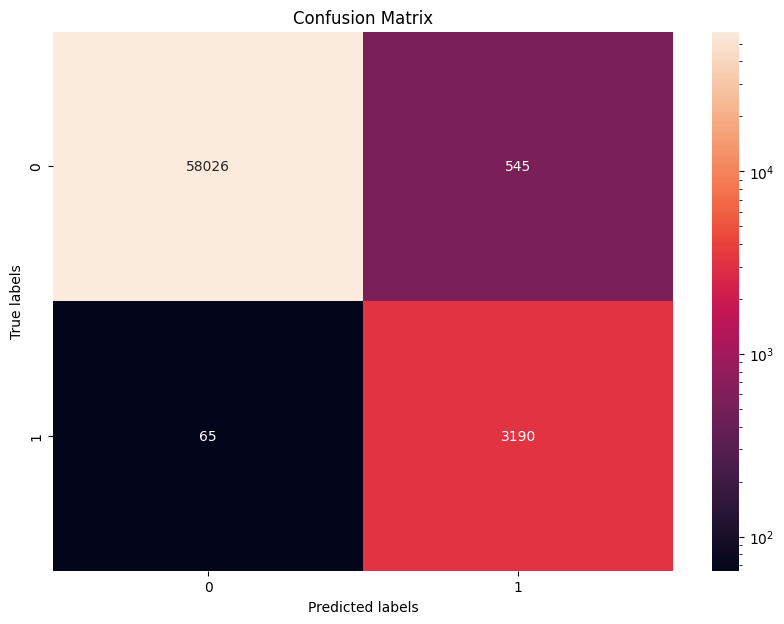

F1 Score: 0.9905


In [60]:
# Convert lists to numpy arrays for use with scikit-learn
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

# Compute the confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)
# print("Confusion Matrix:\n", conf_matrix)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='g', norm=matplotlib.colors.LogNorm())
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Compute the F1 score
f1 = f1_score(all_labels, all_predictions, average='weighted')  # 'weighted' accounts for label imbalance
print("F1 Score: {:.4f}".format(f1))

#### Pre-process Test Data

In [113]:
# train['conversation'].items()
sentence1_list = []
sentence2_list = []
nsp_label = []

for conv_id, conversation in test['conversation'].items():
    
    # Get Causal Range of ids for conversation
    min_utt_id = conversation[0]['utterance_ID']
    max_utt_id = conversation[-1]['utterance_ID']
    causal_range = return_causal_range_tuples(min_utt_id, max_utt_id)
    # print(causal_range)

    # Get all emotion-cause ids from pairs
    ec_ids = preprocess_ec_pairs(test['emotion-cause_pairs'][conv_id])
    # print(ec_ids)

    # Obtain only non-self-matching (for NSP) and reverse the ids (so that they're causal)
    label1_nsp = inverse_non_self_matching_ec_pairs_for_nsp(non_self_matching_ec_pairs(ec_ids))
    # print(label1_nsp)

    for id1 in range(1, max_utt_id):
        for id2 in range(id1 + 1, max_utt_id+1):  # Start from id1+1 to avoid self matching
            # print(id1, id2)
            # Find the utterances in the conversation with id1 and id2
            sentence1 = next((utt['text'] for utt in conversation if utt['utterance_ID'] == id1), None)
            sentence2 = next((utt['text'] for utt in conversation if utt['utterance_ID'] == id2), None)
    
            # Check if both sentences were found
            if sentence1 is not None and sentence2 is not None:
                if (id1, id2) in label1_nsp:
                    label = 1
                else:
                    label = 0
    
                sentence1_list.append(sentence1)
                sentence2_list.append(sentence2)
                nsp_label.append(label)


    # break

In [114]:
print(len(sentence1_list), len(sentence2_list), len(nsp_label))

20759 20759 20759


In [115]:
true_labels = 0
for label in nsp_label:
    if label == 1:
       true_labels += 1

print(f"True Labels: {true_labels}; False Labels: {len(nsp_label) - true_labels}") 

True Labels: 1019; False Labels: 19740


#### Test Dataloader

In [116]:
# Example data (Replace with your dataset)
# texts = [("Sentence 1 of pair 1", "Sentence 2 of pair 1"), ("Sentence 1 of pair 2", "Sentence 2 of pair 2"), ...]
texts = [(sentence1, sentence2) for sentence1, sentence2 in zip(sentence1_list, sentence2_list)]
# labels = [0, 1, ...]  # 0 if not a logical follow-up, 1 if it is
labels = nsp_label

# Initialize tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# model = BertForNextSentencePrediction.from_pretrained('bert-base-uncased')
# model = model.to(device)

# Tokenization
max_length = 256  # Set a maximum length. Choose a value that suits your data.
tokenized_input = [tokenizer(text[0], text[1], padding='max_length', max_length=max_length, truncation=True, return_tensors='pt') for text in texts]

input_ids = torch.cat([t["input_ids"] for t in tokenized_input], dim=0)
attention_masks = torch.cat([t["attention_mask"] for t in tokenized_input], dim=0)
labels = torch.tensor(labels)

# Create DataLoader
test_dataset = TensorDataset(input_ids, attention_masks, labels)
test_dataloader = DataLoader(test_dataset, batch_size=64)

# Optimizer
# optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

#### View Test accuracy and test confusion matrix

In [154]:
%%time
# Set the model to evaluation mode
model.eval()

# Lists to store true labels and predictions
all_labels = []
all_predictions = []

with torch.no_grad():
    for batch in test_dataloader:
        # Unpack the batch data and move to the same device as model
        b_input_ids, b_input_mask, b_labels = tuple(t.to(device) for t in batch)

        # Make predictions
        outputs = bert_nsp_model(input_ids=b_input_ids, attention_mask=b_input_mask)
        predictions = torch.argmax(outputs.logits, dim=1)

        # Store predictions and true labels
        all_labels.extend(b_labels.tolist())
        all_predictions.extend(predictions.tolist())

CPU times: user 1min 6s, sys: 270 ms, total: 1min 6s
Wall time: 1min 6s


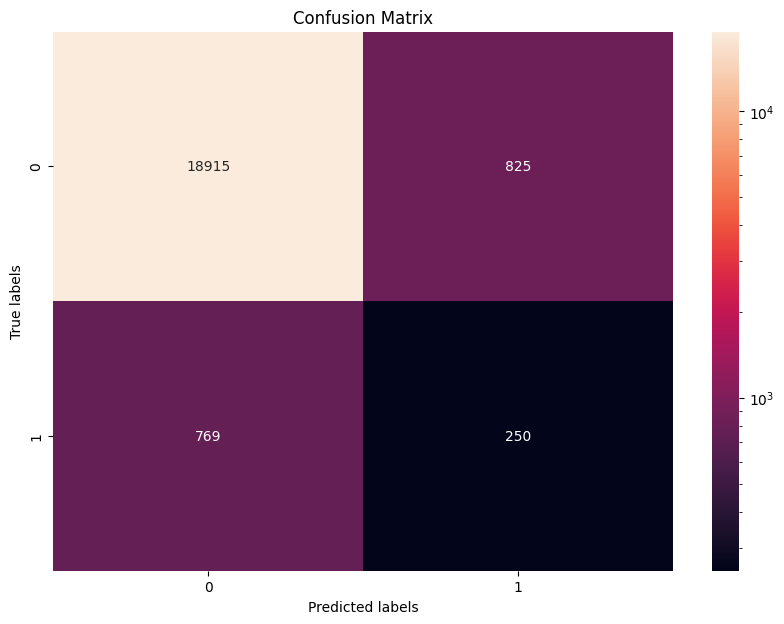

F1 Score: 0.9242


In [156]:
# Convert lists to numpy arrays for use with scikit-learn
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

# Compute the confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)
# print("Confusion Matrix:\n", conf_matrix)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='g', norm=matplotlib.colors.LogNorm())
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Compute the F1 score
f1 = f1_score(all_labels, all_predictions, average='weighted')  # 'weighted' accounts for label imbalance
print("F1 Score: {:.4f}".format(f1))

## 2. Check Emotion-Cause Pairs Accuracy (without span)

In [168]:
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_nsp_model = BertForNextSentencePrediction.from_pretrained('bert-base-uncased')
bert_nsp_model.load_state_dict(torch.load('bert_10_epoch_nsp.pth')['model_state_dict'])
bert_nsp_model = bert_nsp_model.to(device)
bert_nsp_model.eval()

BertForNextSentencePrediction(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [131]:
# inputs = bert_tokenizer(sentence1, sentence2, return_tensors='pt')
# print(inputs)

In [132]:
sentiment_tokenizer = AutoTokenizer.from_pretrained("thesergiu/finetuning-sentiment-model-10k-samples")
# sentiment_model = AutoModelForSequenceClassification.from_pretrained(
#     "thesergiu/finetuning-sentiment-model-10k-samples", 
# )
# sentiment_model = sentiment_model.to(device)
emotion_classifier = pipeline("sentiment-analysis", model="thesergiu/finetuning-sentiment-model-10k-samples")

In [133]:
emotion_classifier("This sucks!")[0]

{'label': 'disgust', 'score': 0.495368093252182}

### Check Train Accuracy / F1 on all emotion-cause pairs

In [198]:
%%time
# train['conversation'].items()
sentence1_list = []
sentence2_list = []
labels = []
predictions = []

for conv_id, conversation in train['conversation'].items():
    
    # Get Causal Range of ids for conversation
    min_utt_id = conversation[0]['utterance_ID']
    max_utt_id = conversation[-1]['utterance_ID']
    causal_range = return_causal_range_tuples(min_utt_id, max_utt_id)
    # print(causal_range)

    # Get all emotion-cause ids from pairs
    ec_ids = preprocess_ec_pairs(train['emotion-cause_pairs'][conv_id])
    # print(ec_ids)

    # Obtain only non-self-matching (for NSP) and reverse the ids (so that they're causal)
    label1_nsp = inverse_non_self_matching_ec_pairs_for_nsp(non_self_matching_ec_pairs(ec_ids))
    # print(label1_nsp)

    for id1 in range(1, max_utt_id):
        for id2 in range(id1, max_utt_id):  # Start from id1+1 to avoid self matching
            # print(id1, id2)

            # This means we have a potential self-match pair, we have to perform sentiment analysis
            if id1 == id2:

                # If pair is present in emotion-cause pairs, label is 1. 0 otherwise
                if (str(id1), str(id2)) in ec_ids:
                    labels.append(1)
                else:
                    labels.append(0)
                
                # Find the utterances in the conversation with id1 (and id2)
                sentence = next((utt['text'] for utt in conversation if utt['utterance_ID'] == id1), None)

                # Compute score and label
                emotion_clasif_output = emotion_classifier(sentence)[0]

                # If label is anything but neutral (with high confidence), label is 1
                if emotion_clasif_output['label'] != 'neutral' and emotion_clasif_output['score'] > 0.5:
                    predictions.append(1)
                else:
                    predictions.append(0)

            else:
                # Find the utterances in the conversation with id1 and id2
                sentence1 = next((utt['text'] for utt in conversation if utt['utterance_ID'] == id1), None)
                sentence2 = next((utt['text'] for utt in conversation if utt['utterance_ID'] == id2), None)

                # Check if both sentences were found
                if sentence1 is not None and sentence2 is not None:

                    # Tokenize the sentences
                    # Tokenization
                    inputs = bert_tokenizer(sentence1, sentence2, padding='max_length', max_length=256, truncation=True, return_tensors='pt')
                    
                    # print(inputs.keys())

                    # Add label
                    if (id1, id2) in label1_nsp:
                        label = 1
                    else:
                        label = 0

                    labels.append(label)
                    
                    # # Create Class Label
                    # cls_label = torch.LongTensor([label])
                    # # print(labels)
                    
                    # Compute Loss                  
                    utputs = bert_nsp_model(input_ids=inputs['input_ids'].to(device), attention_mask=inputs['attention_mask'].to(device))
                    # print("Outputs:", outputs.keys())
                    
                    # Compute Prediction
                    prediction = torch.argmax(outputs.logits, dim=1)
                    # print("Prediction:", prediction)
                    predictions.append(prediction.cpu().int().item())  

    # print(predictions)
    # print(labels)
    # break

CPU times: user 18min 25s, sys: 34.4 s, total: 18min 59s
Wall time: 7min 47s


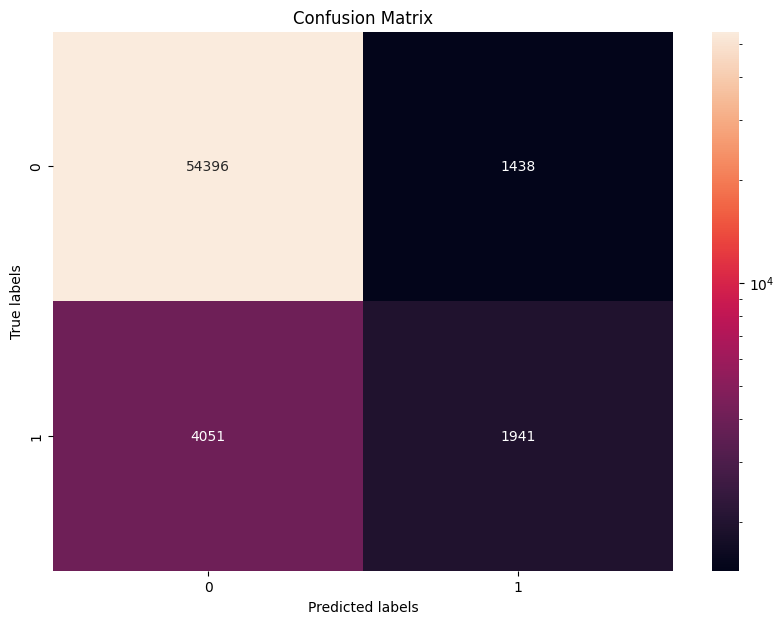

F1 Score: 0.8999


In [199]:
# Convert lists to numpy arrays for use with scikit-learn
all_labels = np.array(labels)
all_predictions = np.array(predictions)

# Compute the confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)
# print("Confusion Matrix:\n", conf_matrix)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='g', norm=matplotlib.colors.LogNorm())
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Compute the F1 score
f1 = f1_score(all_labels, all_predictions, average='weighted')  # 'weighted' accounts for label imbalance
print("F1 Score: {:.4f}".format(f1))

### Check Test Accuracy / F1 on all emotion-cause pairs

In [194]:
%%time
# train['conversation'].items()
sentence1_list = []
sentence2_list = []
labels = []
predictions = []

for conv_id, conversation in test['conversation'].items():
    
    # Get Causal Range of ids for conversation
    min_utt_id = conversation[0]['utterance_ID']
    max_utt_id = conversation[-1]['utterance_ID']
    causal_range = return_causal_range_tuples(min_utt_id, max_utt_id)
    # print(causal_range)

    # Get all emotion-cause ids from pairs
    ec_ids = preprocess_ec_pairs(test['emotion-cause_pairs'][conv_id])
    # print(ec_ids)

    # Obtain only non-self-matching (for NSP) and reverse the ids (so that they're causal)
    label1_nsp = inverse_non_self_matching_ec_pairs_for_nsp(non_self_matching_ec_pairs(ec_ids))
    # print(label1_nsp)

    matching_ids = []

    for id1 in range(1, max_utt_id + 1):
        for id2 in range(id1, max_utt_id + 1):  # Start from id1+1 to avoid self matching
            # print(id1, id2)

            # This means we have a potential self-match pair, we have to perform sentiment analysis
            if id1 == id2:

                # If pair is present in emotion-cause pairs, label is 1. 0 otherwise
                if (str(id1), str(id2)) in ec_ids:
                    matching_ids.append((str(id1), str(id2)))
                    labels.append(1)
                else:
                    labels.append(0)
                
                # Find the utterances in the conversation with id1 (and id2)
                sentence = next((utt['text'] for utt in conversation if utt['utterance_ID'] == id1), None)

                # Compute score and label
                emotion_clasif_output = emotion_classifier(sentence)[0]

                # If label is anything but neutral, label is 1
                if emotion_clasif_output['label'] != 'neutral' and emotion_clasif_output['score'] > 0.5:
                    predictions.append(1)
                else:
                    predictions.append(0)

            else:
                # Find the utterances in the conversation with id1 and id2
                sentence1 = next((utt['text'] for utt in conversation if utt['utterance_ID'] == id1), None)
                sentence2 = next((utt['text'] for utt in conversation if utt['utterance_ID'] == id2), None)

                # Check if both sentences were found
                if sentence1 is not None and sentence2 is not None:

                    # Tokenize the sentences
                    # Tokenization
                    inputs = bert_tokenizer(sentence1, sentence2, padding='max_length', max_length=256, truncation=True, return_tensors='pt')

                    # Add label
                    if (id1, id2) in label1_nsp:
                        label = 1
                    else:
                        label = 0

                    labels.append(label)
                    
                    # # Create Class Label
                    cls_label = torch.LongTensor([label])
                    # # print(labels)
                    
                    # Compute Loss
                    # TODO: Maybe remove labels here?
                    outputs = bert_nsp_model(input_ids=inputs['input_ids'].to(device), attention_mask=inputs['attention_mask'].to(device))
                    # print("Outputs:", outputs.keys())
                    
                    # Compute Prediction
                    prediction = torch.argmax(outputs.logits, dim=1)
                    # print("Prediction:", prediction)
                    predictions.append(prediction.cpu().int().item())  
    # print(matching_ids)
    # print(predictions)
    # print(labels)
    # break

CPU times: user 7min 4s, sys: 13.7 s, total: 7min 18s
Wall time: 3min 6s


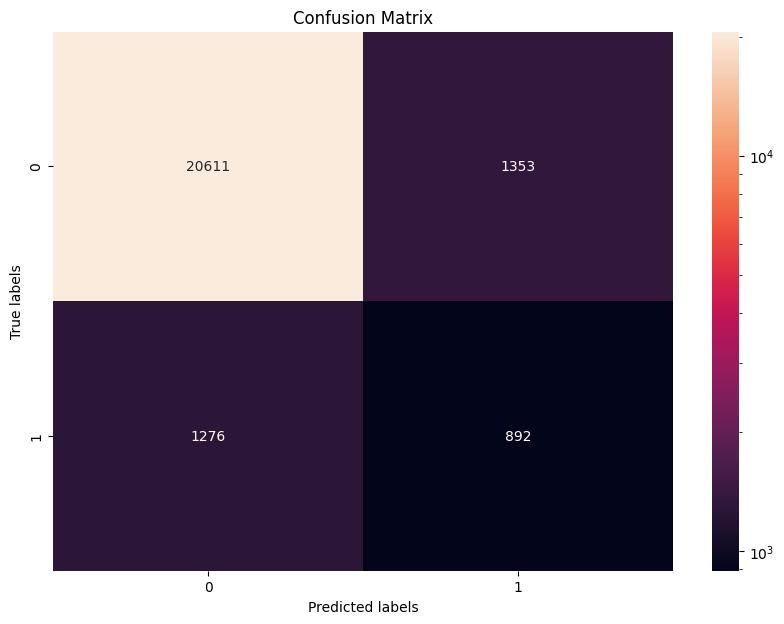

F1 Score: 0.8919


In [197]:
# Convert lists to numpy arrays for use with scikit-learn
all_labels = np.array(labels)
all_predictions = np.array(predictions)

# Compute the confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)
# print("Confusion Matrix:\n", conf_matrix)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='g', norm=matplotlib.colors.LogNorm())
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Compute the F1 score
f1 = f1_score(all_labels, all_predictions, average='weighted')  # 'weighted' accounts for label imbalance
print("F1 Score: {:.4f}".format(f1))

## End Of Notebook